### Model Development ###

Up to this point our efforts have been focused on the selection of training pairs or correspondences. These pairs consist of locations of pixels that are in the shade, and associated pixel lists that *may* be the same surface type, but are out in the open. Using the spectral information of the pixels in the open, we develop a model aimed at learning the local radiance attenuation.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from hyperspectral import *
import pandas as pd
import numpy as np
import pickle

correspondences = pickle.load(open('data/training_correspondences.p', 'rb'))
hsi_import = np.load('data/hsi_data.npz')
hsi_data = hsi_import['hyperspectral_data']
wavelengths = hsi_import['wavelengths']

#### Compiling Observations and Targets ####

Given the correspondences determined in previous steps, we can build the data sets we wish to use in training our models. From the correspondence pairs we have our observations, the pixels in the shade, and a batch of candidate targets, pixels to believed to represent the same material in direct sunlight.  

As the 'candidate' pixels in the open are subject to a degree of variation, we'll run our initial tests using the pixels with the minimum norm, median norm,  and maximum norm. Subsequent model assessments can be utilized to determine which is best going forward.

In [13]:
hsi_data_matrix = multispectral_raster_to_matrix(hsi_data)
image_width = hsi_data.shape[1]

observation_indices = []
min_target_indices = []
med_target_indices = []
max_target_indices = []

for pixel in correspondences:

    observation_indices.append(pixel[0] * image_width + pixel[1])
    
    # compute spectra norms for all corresponding pixels; select the min, median, and max
    open_norms = [ np.linalg.norm(get_spectrum(hsi_data, px)) for px in correspondences[pixel] ]
    norm_indices = np.argsort(open_norms)
    min_norm_pixel = correspondences[pixel][norm_indices[0]]
    med_norm_pixel = correspondences[pixel][norm_indices[len(norm_indices)//2]]
    max_norm_pixel = correspondences[pixel][norm_indices[-1]]
    
    min_target_indices.append(min_norm_pixel[0] * image_width + min_norm_pixel[1])
    med_target_indices.append(med_norm_pixel[0] * image_width + med_norm_pixel[1])
    max_target_indices.append(max_norm_pixel[0] * image_width + max_norm_pixel[1])

observation_matrix = hsi_data_matrix[observation_indices, :]
target_matrices = { 'min' : hsi_data_matrix[min_target_indices, :], 
                   'median' : hsi_data_matrix[med_target_indices, :],
                   'max' : hsi_data_matrix[max_target_indices, :] }

#### Reduced Space Ridge Regression ####

As an initial example we evaluate the output of a kernel ridge regression model trained on a reduced dimensionality version of our data. 

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from pca import principal_components

number_dimensions = 18

pc = principal_components(hsi_data_matrix)
reduced_observation_matrix = pc.reduce_dimension(observation_matrix, number_dimensions)
reduced_target_matrices = {}
for label in target_matrices:
    reduced_target_matrices[label] = pc.reduce_dimension(target_matrices[label], number_dimensions)

In [20]:
parameters = { 'alpha': [ 0.1, 0.05, 0.01, 0.005 ], 'gamma': [ 1.0, 5.0, 10.0, 50.0  ], 'kernel' : ['linear', 'rbf'] }
model = GridSearchCV(KernelRidge(), parameters, scoring='neg_mean_squared_error', cv=10)

best_model_params = {}

for label in reduced_target_matrices:
    model.fit(reduced_observation_matrix, reduced_target_matrices[label])
    best_model_params[label] = model.best_params_
    print('\nEvaluating model using', label, 'candidate spectra...')
    print('CV RMSE: {:.3f}'.format(-model.best_score_))
    print('CV Selected Parameters:', model.best_params_)


Evaluating model using min candidate spectra...
CV RMSE: 0.009
CV Selected Parameters: {'alpha': 0.05, 'gamma': 5.0, 'kernel': 'rbf'}

Evaluating model using median candidate spectra...
CV RMSE: 0.010
CV Selected Parameters: {'alpha': 0.05, 'gamma': 5.0, 'kernel': 'rbf'}

Evaluating model using max candidate spectra...
CV RMSE: 0.018
CV Selected Parameters: {'alpha': 0.1, 'gamma': 10.0, 'kernel': 'rbf'}


#### Min Spectra Model Plots ####

In experiments thus far kernel ridge regression has performed best using the minimum corresponding spectra. As a quick visual example we plot the spectra of several observations in the shade against their minimum-norm correspondence, as well as what the model trained on minimum-norm correspondences estimates the unobstructed radiance should be.

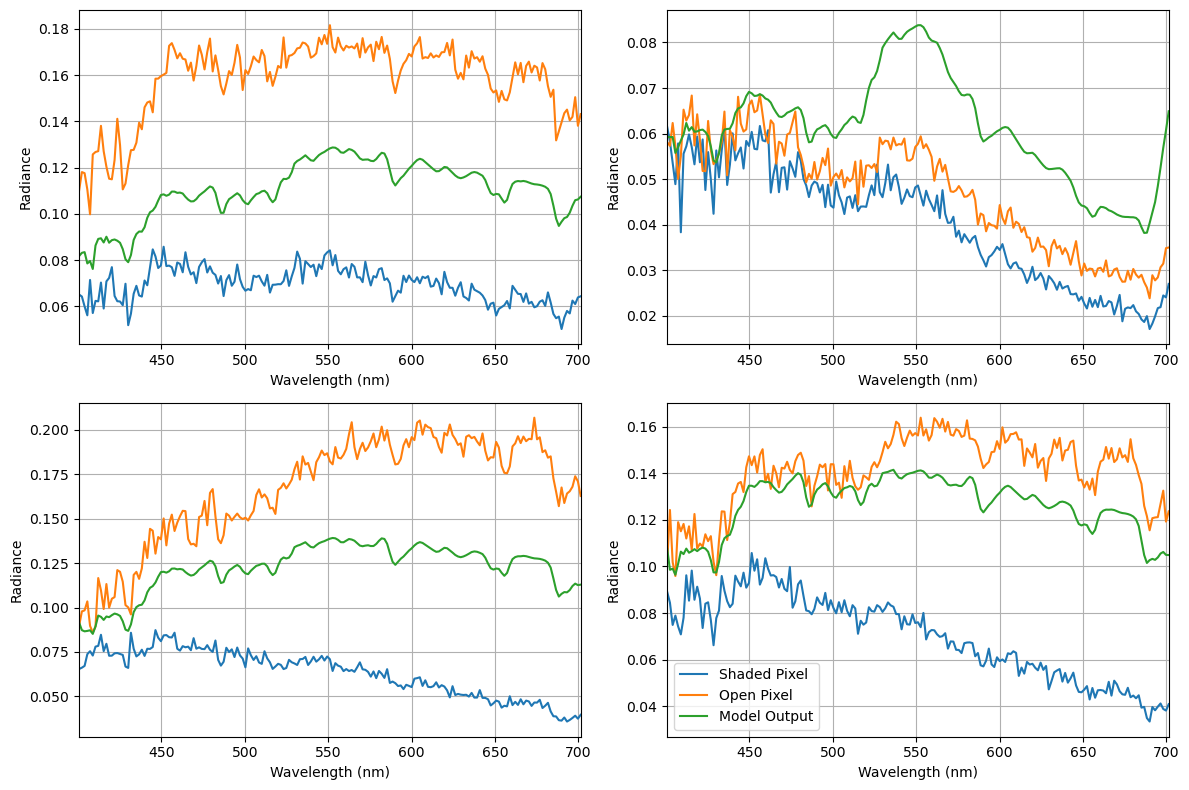

In [19]:
min_krr_model = KernelRidge(**best_model_params['min'])
min_krr_model.fit(reduced_observation_matrix, reduced_target_matrices['min'])

reduced_space_predictions = min_krr_model.predict(reduced_observation_matrix)
reconstructed_predictions = pc.reconstruct(reduced_space_predictions)

plt.figure(figsize=(12,8))
for plot in [ 221, 222, 223, 224 ]:
    
    sample_index = np.random.randint(0, len(observation_indices))
    spectra = [ 
        observation_matrix[sample_index, :], 
        target_matrices['min'][sample_index, :],
        reconstructed_predictions[sample_index, :] 
    ]

    plt.subplot(plot)
    if plot == 224:
        spectra_plot(wavelengths, np.array(spectra), legend_labels=['Shaded Pixel', 'Open Pixel', 'Model Output'])
    else : spectra_plot(wavelengths, np.array(spectra))

plt.tight_layout()
plt.show()